In [1]:
import fortranmagic
import IPython
import IPython.core.magics.execution
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn

seaborn.set()

In [2]:
print(f"fortranmagic.__version__: {fortranmagic.__version__}")
print(f"IPython.__version__:      {IPython.__version__}")
print(f"matplotlib.__version__:   {matplotlib.__version__}")
print(f"numpy.__version__:        {np.__version__}")
print(f"seaborn.__version__:      {seaborn.__version__}")

fortranmagic.__version__: 0.6.1
IPython.__version__:      7.10.2
matplotlib.__version__:   3.1.2
numpy.__version__:        1.18.0
seaborn.__version__:      0.9.0


## Inputs: 

- 2D vector `nodes` ($b$) of shape `(d, N + 1)` (each column is a `d`-dimensional vector)
- 1D vector `s_vals` ($s$) of shape `(k,)`

## Output:

- 2D vector `points` ($p$) of shape `(d, k)`

## Algorithm:

For every single value $s_j$ in $s$, we ["reduce" the number][1] of columns by 1 at each step, for example
$$\begin{align*}
b^{(N, j)} &= b \\
b^{(N - 1, j)} &= (1 - s_j) \, b^{(N, j)}_{:, \, 0:N - 1} + s_j \, b^{(N, j)}_{:, \, 1:N} \\
&\vdots \\
b^{(1, j)} &= (1 - s_j) \, b^{(2, j)}_{:, \, 0:1} + s_j \, b^{(2, j)}_{:, \, 1:2} \\
b^{(0, j)} &= (1 - s_j) \, b^{(1, j)}_{:, \, 0} + s_j \, b^{(1, j)}_{:, \, 1}
\end{align*}$$

The result has each of these reduced values as its columns
$$p_j = b^{(0, j)}.$$

[1]: https://en.wikipedia.org/wiki/De_Casteljau%27s_algorithm

In [3]:
%load_ext fortranmagic

${HERE}/.venv/lib/python3.7/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [4]:
%%fortran

subroutine spread_dimension1( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: broadcast_s(num_vals, dimension_, num_nodes)
  real(c_double) :: broadcast_one_less(num_vals, dimension_, num_nodes)
  real(c_double) :: workspace(num_vals, dimension_, num_nodes)
  integer(c_int) :: i

  one_less = 1.0_dp - s_vals
  ! s_vals:                        [num_vals]
  ! SPREAD(s_vals, 2, dimension_): [num_vals, dimension_]
  ! broadcast_s:                   [num_vals, dimension_, num_nodes]
  broadcast_s = SPREAD(SPREAD(s_vals, 2, dimension_), 3, num_nodes)
  broadcast_one_less = SPREAD(SPREAD(one_less, 2, dimension_), 3, num_nodes)

  workspace = SPREAD(nodes, 1, num_vals)
  do i = num_nodes - 1, 1, -1
     workspace(:, :, 1:i) = ( &
          broadcast_one_less(:, :, 1:i) * workspace(:, :, 1:i) + &
          broadcast_s(:, :, 2:i + 1) * workspace(:, :, 2:i + 1))
  end do
  evaluated = TRANSPOSE(workspace(:, :, 1))

end subroutine spread_dimension1

In [5]:
%%fortran

subroutine spread_dimension2( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: broadcast_s(dimension_, num_vals, num_nodes)
  real(c_double) :: broadcast_one_less(dimension_, num_vals, num_nodes)
  real(c_double) :: workspace(dimension_, num_vals, num_nodes)
  integer(c_int) :: i

  one_less = 1.0_dp - s_vals
  ! s_vals:                        [num_vals]
  ! SPREAD(s_vals, 1, dimension_): [dimension_, num_vals]
  ! broadcast_s:                   [dimension_, num_vals, num_nodes]
  broadcast_s = SPREAD(SPREAD(s_vals, 1, dimension_), 3, num_nodes)
  broadcast_one_less = SPREAD(SPREAD(one_less, 1, dimension_), 3, num_nodes)

  workspace = SPREAD(nodes, 2, num_vals)
  do i = num_nodes - 1, 1, -1
     workspace(:, :, 1:i) = ( &
          broadcast_one_less(:, :, 1:i) * workspace(:, :, 1:i) + &
          broadcast_s(:, :, 2:i + 1) * workspace(:, :, 2:i + 1))
  end do
  evaluated = workspace(:, :, 1)

end subroutine spread_dimension2

In [6]:
%%fortran

subroutine spread_dimension3( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: broadcast_s(dimension_, num_nodes, num_vals)
  real(c_double) :: broadcast_one_less(dimension_, num_nodes, num_vals)
  real(c_double) :: workspace(dimension_, num_nodes, num_vals)
  integer(c_int) :: i

  one_less = 1.0_dp - s_vals
  ! s_vals:                        [num_vals]
  ! SPREAD(s_vals, 1, dimension_): [dimension_, num_vals]
  ! broadcast_s:                   [dimension_, num_nodes, num_vals]
  broadcast_s = SPREAD(SPREAD(s_vals, 1, dimension_), 2, num_nodes)
  broadcast_one_less = SPREAD(SPREAD(one_less, 1, dimension_), 2, num_nodes)

  workspace = SPREAD(nodes, 3, num_vals)
  do i = num_nodes - 1, 1, -1
     workspace(:, 1:i, :) = ( &
          broadcast_one_less(:, 1:i, :) * workspace(:, 1:i, :) + &
          broadcast_s(:, 2:i + 1, :) * workspace(:, 2:i + 1, :))
  end do
  evaluated = workspace(:, 1, :)

end subroutine spread_dimension3

In [7]:
%%fortran

subroutine forall1( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: workspace(num_vals, dimension_, num_nodes)
  integer(c_int) :: i, j

  one_less = 1.0_dp - s_vals

  forall (j = 1:num_vals)
     workspace(j, :, :) = nodes
  end forall

  do i = num_nodes - 1, 1, -1
     forall (j = 1:num_vals)
        workspace(j, :, 1:i) = ( &
             one_less(j) * workspace(j, :, 1:i) + &
             s_vals(j) * workspace(j, :, 2:i + 1))
     end forall
  end do
  evaluated = TRANSPOSE(workspace(:, :, 1))

end subroutine forall1

In [8]:
%%fortran

subroutine forall2( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: workspace(dimension_, num_vals, num_nodes)
  integer(c_int) :: i, j

  one_less = 1.0_dp - s_vals

  forall (j = 1:num_vals)
     workspace(:, j, :) = nodes
  end forall

  do i = num_nodes - 1, 1, -1
     forall (j = 1:num_vals)
        workspace(:, j, 1:i) = ( &
             one_less(j) * workspace(:, j, 1:i) + &
             s_vals(j) * workspace(:, j, 2:i + 1))
     end forall
  end do
  evaluated = workspace(:, :, 1)

end subroutine forall2

In [9]:
%%fortran

subroutine forall3( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: workspace(dimension_, num_nodes, num_vals)
  integer(c_int) :: i, j

  one_less = 1.0_dp - s_vals

  forall (j = 1:num_vals)
     workspace(:, :, j) = nodes
  end forall

  do i = num_nodes - 1, 1, -1
     forall (j = 1:num_vals)
        workspace(:, 1:i, j) = ( &
             one_less(j) * workspace(:, 1:i, j) + &
             s_vals(j) * workspace(:, 2:i + 1, j))
     end forall
  end do
  evaluated = workspace(:, 1, :)

end subroutine forall3

In [10]:
%%fortran

subroutine serial( &
     num_nodes, dimension_, nodes, num_vals, s_vals, evaluated)

  use, intrinsic :: iso_c_binding, only: c_double, c_int
  integer, parameter :: dp = kind(0.d0)

  integer(c_int), intent(in) :: num_nodes, dimension_
  real*8, intent(in) :: nodes(dimension_, num_nodes)  ! Non-"modern" `real*8` for f2py
  integer(c_int), intent(in) :: num_vals
  real*8, intent(in) :: s_vals(num_vals)  ! Non-"modern" `real*8` for f2py
  real*8, intent(out) :: evaluated(dimension_, num_vals)  ! Non-"modern" `real*8` for f2py
  ! Variables outside of signature.
  real(c_double) :: one_less(num_vals)
  real(c_double) :: workspace(dimension_, num_nodes)
  integer(c_int) :: i, j

  one_less = 1.0_dp - s_vals

  do j = 1, num_vals
     workspace = nodes
     do i = num_nodes - 1, 1, -1
        workspace(:, 1:i) = ( &
             one_less(j) * workspace(:, 1:i) + &
             s_vals(j) * workspace(:, 2:i + 1))
     end do
     evaluated(:, j) = workspace(:, 1)
  end do

end subroutine serial

In [11]:
def verify_implementations(nodes, s_vals):
    points1 = spread_dimension1(nodes, s_vals)
    points2 = spread_dimension2(nodes, s_vals)
    points3 = spread_dimension3(nodes, s_vals)
    points4 = forall1(nodes, s_vals)
    points5 = forall2(nodes, s_vals)
    points6 = forall3(nodes, s_vals)
    points7 = serial(nodes, s_vals)
    
    return (
        np.all(points1 == points2),
        np.all(points1 == points3),
        np.all(points1 == points4),
        np.all(points1 == points5),
        np.all(points1 == points6),
        np.all(points1 == points7),
    )

In [12]:
random_state = np.random.RandomState(seed=798031893)
x = sorted(random_state.randint(1000, size=31))
y = sorted(random_state.randint(1000, size=31))
nodes = np.asfortranarray([x, y])

s_vals = np.linspace(0.0, 1.0, 33)

verify_implementations(nodes, s_vals)

(True, True, True, True, True, True)

# Bake-off: 31 nodes and 33 values

In [13]:
%timeit spread_dimension1(nodes, s_vals)

28.7 µs ± 644 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit spread_dimension2(nodes, s_vals)

67.9 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit spread_dimension3(nodes, s_vals)

68.9 µs ± 2.34 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit forall1(nodes, s_vals)

34.2 µs ± 765 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit forall2(nodes, s_vals)

44.4 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit forall3(nodes, s_vals)

45.5 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%timeit serial(nodes, s_vals)

46.7 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
magics = IPython.core.magics.execution.ExecutionMagics(
    IPython.get_ipython()
)
by_size = {}
nodes_sizes = np.array([2 ** n for n in range(9)])
possible_s_vals = (3, 9, 33, 129, 513)

In [21]:
for num_nodes in nodes_sizes:
    # Re-start random state so ordering doesn't matter.
    random_state = np.random.RandomState(seed=798031893)
    x = sorted(random_state.randint(1000, size=num_nodes))
    y = sorted(random_state.randint(1000, size=num_nodes))
    nodes = np.asfortranarray([x, y])

    for num_s_vals in possible_s_vals:
        s_vals = np.linspace(0.0, 1.0, num_s_vals)
        key = ("forall1", num_nodes, num_s_vals)
        by_size[key] = magics.timeit("-o -q forall1(nodes, s_vals)")
        key = ("spread_dimension1", num_nodes, num_s_vals)
        by_size[key] = magics.timeit("-o -q spread_dimension1(nodes, s_vals)") 
        key = ("serial", num_nodes, num_s_vals)
        by_size[key] = magics.timeit("-o -q serial(nodes, s_vals)")

In [22]:
def plot_data(ax, nodes_sizes, by_size, num_s_vals):
    for fn_name in ("forall1", "spread_dimension1", "serial"):
        y_vals = []
        y_below = []
        y_above = []
        for num_nodes in nodes_sizes:
            timeit_result = by_size[(fn_name, num_nodes, num_s_vals)]
            y_vals.append(timeit_result.average)
            # 2 std deviations ~= 95%
            y_below.append(timeit_result.average - 2.0 * timeit_result.stdev)
            y_above.append(timeit_result.average + 2.0 * timeit_result.stdev)
            
        line, = ax.loglog(nodes_sizes, y_vals, marker="o", label=fn_name)
        ax.fill_between(
            nodes_sizes,
            y_below,
            y_above,
            alpha=0.5,
            color=line.get_color(),
        )

    ax.set_xscale("log", basex=2)
    ax.set_yscale("log", basey=2)
    ax.set_title(f"Number of Input Values: {num_s_vals}")
    ax.set_xlabel("Number of Nodes")
    ax.set_ylabel("Average Evaluation Time (s)")
    ax.legend()

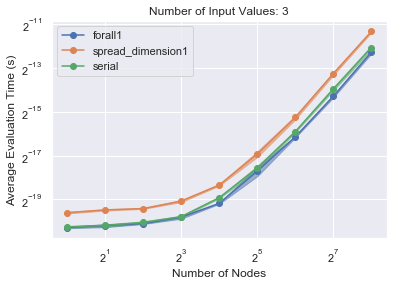

In [23]:
figure = plt.figure()
plot_data(figure.gca(), nodes_sizes, by_size, 3)

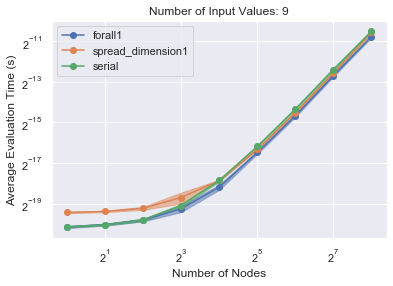

In [24]:
figure = plt.figure()
plot_data(figure.gca(), nodes_sizes, by_size, 9)

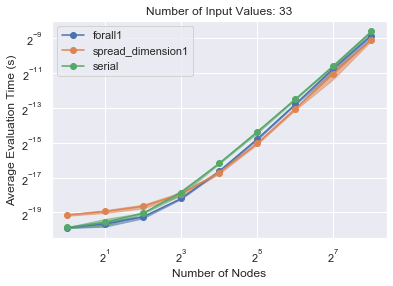

In [25]:
figure = plt.figure()
plot_data(figure.gca(), nodes_sizes, by_size, 33)

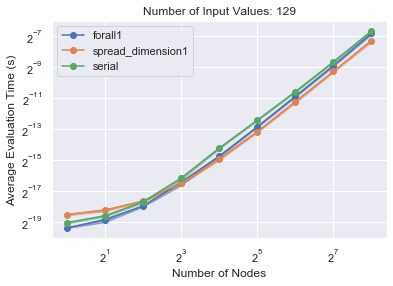

In [26]:
figure = plt.figure()
plot_data(figure.gca(), nodes_sizes, by_size, 129)

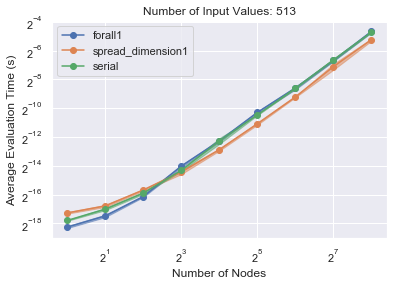

In [27]:
figure = plt.figure()
plot_data(figure.gca(), nodes_sizes, by_size, 513)